# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"

#### Get the gold dataset from https://biocreative.bioinformatics.udel.edu/media/store/files/2017/ChemProt_Corpus.zip

In [2]:
test_gold_file = "../temp/data/chemprot_test_gold_standard.tsv"

In [3]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [4]:
import sys, os, pandas as pd
sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [5]:
local_temp= "temp"

In [6]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)




## Utils

In [7]:
def add_key_column(df):
    df["key"] = df.apply(lambda x:"{}#{}#{}".format( x["abstract_id"], x["participant1_id"].replace("Arg1:",""), x["participant2_id"].replace("Arg2:","")), axis=1)
    return df

def load_gold(file):
    df = pd.read_csv(file, delimiter="\t", header=None, names = ["abstract_id", "relationship_type", "participant1_id","participant2_id"])
    
    return df

In [8]:


def load_valtest_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x))
    df["y_raw"] = df["prediction"]


    df["x"] = df["sentence_anonymised"].apply(lambda x: x.replace("_GENE-Y_", "_GENE_")
                                                                .replace("_GENE-N_", "_GENE_"))
    df["gold"] = df["label"].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df["label"]


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [9]:
from model_nb_classifier import ModelNBClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier



def train_and_predict(df, min_df=None):
    m = ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df, trigger_words=trigger_words)
    print(trigger_words)
    #m= ModelNBClassifier("_CHEMICAL_", "_GENE_")
    m.train(df["x"], df["y"])
    return m, m.predict(df["x"])[0]



In [10]:
import tempfile

def isint(a):
    try:
        t = int(a)
        return True
    except:
        return False

def float_percent_format(x):
     return "{:.1f}".format(x*100)

def int_format(x):
     return str(int(x))

def print_report(actual, pred, latex=True, labels=None, label_names = all_labels):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=labels,zero_division=0)
        df =  pd.DataFrame(d).T
        df.index = list(map(lambda x: label_names[int(x)] if isint( x) else x, df.index))
        
        print(df.to_latex(formatters = {"precision": float_percent_format, "recall":float_percent_format, "f1-score":float_percent_format,"support":int_format }))
        return df
    

    
    

In [11]:
    
import subprocess

def _write_chemprot_eval(df,y_col, dest_file):
    df = df[["abstract_id",y_col, "participant1_id", "participant2_id"]].query(f"{y_col} != 'NEGATIVE' ").copy(deep=True)
    

    df["participant1_id"] = df["participant1_id"].apply(lambda x: f"Arg1:{x}")
    df["participant2_id"] = df["participant2_id"].apply(lambda x: f"Arg2:{x}")
    df.to_csv(dest_file, sep="\t", header=False, index=False)

    
def _run_shell( cmd):
        """
        Runs a shell command
        :param cmd: The cmd to run
        """
        print("Running command\n{}".format(" ".join(cmd)))

        out = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT)
        stdout, stderr = out.communicate()
        result = stdout.decode(encoding='utf-8')
        if stderr:
            error_msg = stderr.decode(encoding='utf-8')
            print(error_msg)
            raise Exception(error_msg)

        return result
    
def print_report_original(df,y_col, gold_file, latex=True,  jar_path="../thirdparty"):
    # Run original eval script to double check numbers
    _, pred_file = tempfile.mkstemp()
    _write_chemprot_eval(df,y_col, pred_file)
    output_dir = "out"
    os.makedirs(output_dir, exist_ok = True)
    cmd = ["java", "-cp" , f"{jar_path}/bc6chemprot_eval.jar", "org.biocreative.tasks.chemprot.main.Main",
           "-TP", "TRUE", "-FP", "TRUE", "-FN", "TRUE", pred_file, gold_file]
    cmd_result = _run_shell(cmd)
    print(cmd_result)

    # Result summary written to eval .txt
    with open(os.path.join(output_dir,"eval.txt"), "r") as f:
        result = f.readlines()
        print(result)
        
    # Parse detailed output file to obtain classwise stats
    names = ["abstract_id", "y", "participant1_id", "participant2_id"]
    df_fp = pd.read_csv(os.path.join(output_dir,"fp.txt"),sep="\t", header=None, names=names)
    df_fp["c"] ="FP"
    df_fn = pd.read_csv(os.path.join(output_dir,"fn.txt"),sep="\t", header=None, names=names)
    df_fn["c"] ="FN"
    df_tp = pd.read_csv(os.path.join(output_dir,"tp.txt"),sep="\t", header=None, names=names)
    df_tp["c"] ="TP"
    df = pd.concat([df_fp, df_tp, df_fn])
    
    df_test_summary = df.groupby(["y" , "c"]).size()\
                .reset_index().rename(columns={0:"total"})\
                .pivot(index="y", columns="c", values="total")
    df_test_summary.loc["total", "FN"] = df_test_summary["FN"].sum()
    df_test_summary.loc["total", "FP"] = df_test_summary["FP"].sum()
    df_test_summary.loc["total", "TP"] = df_test_summary["TP"].sum()

    df_test_summary["P"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FP"])
    df_test_summary["R"] = df_test_summary["TP"].div(df_test_summary["TP"] + df_test_summary["FN"])
    df_test_summary["F"] = (2*df_test_summary["P"] * df_test_summary["R"]).div(df_test_summary["P"] +df_test_summary["R"])


    
    # Clean up
    os.remove(pred_file)
    return df_test_summary

In [12]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [13]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [15]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

## Train GT Train predictions

In [16]:
df_train = load_valtest_pred(local_train_prediction_file)


df_train["shortcut_pred"] = train_and_predict(df_train, min_df=1)[1]



print_report(df_train["gold"],df_train["shortcut_pred"], labels=pos_labels)

['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(6414, 14)
(6414, 14)
              precision    recall  f1-score   support

           1       0.58      0.78      0.66       774
           2       0.83      0.73      0.77      2251
           3       0.81      0.81      0.81       170
           4       0.71      0.87      0.78       229
           5       0.84      0.74      0.79       727

   micro avg       0.76      0.75      0.75      4151
   macro avg       0.75      0.79      0.76      4151
weighted avg       0.77      0.75      0.76      4151

\begin{tabular}{lrrrr}
\toprule
{} & precision & recall & f1-score & support \\
\midrule
1            &      57.6 &   77.9 &     66.2 &     774 \\
2            &      82.6 &   73.0 &     77.5 &    2251 \\
3            &      80.6 &   80.6 &     80.6 &     170 \\
4            &      70.6 &   86.9 &     77.9 &     229 \\
5            &      84.4 &   74.1 &     78.9 &     

,precision,recall,f1-score,support
1,0.575931,0.779070,0.662273,774.0
2,0.826043,0.729898,0.775000,2251.0
3,0.805882,0.805882,0.805882,170.0
4,0.705674,0.868996,0.778865,229.0
5,0.843505,0.741403,0.789165,727.0
micro avg,0.756239,0.751867,0.754047,4151.0
macro avg,0.751407,0.785050,0.762237,4151.0
weighted avg,0.774999,0.751867,0.757940,4151.0


['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(6414, 14)
(6414, 14)


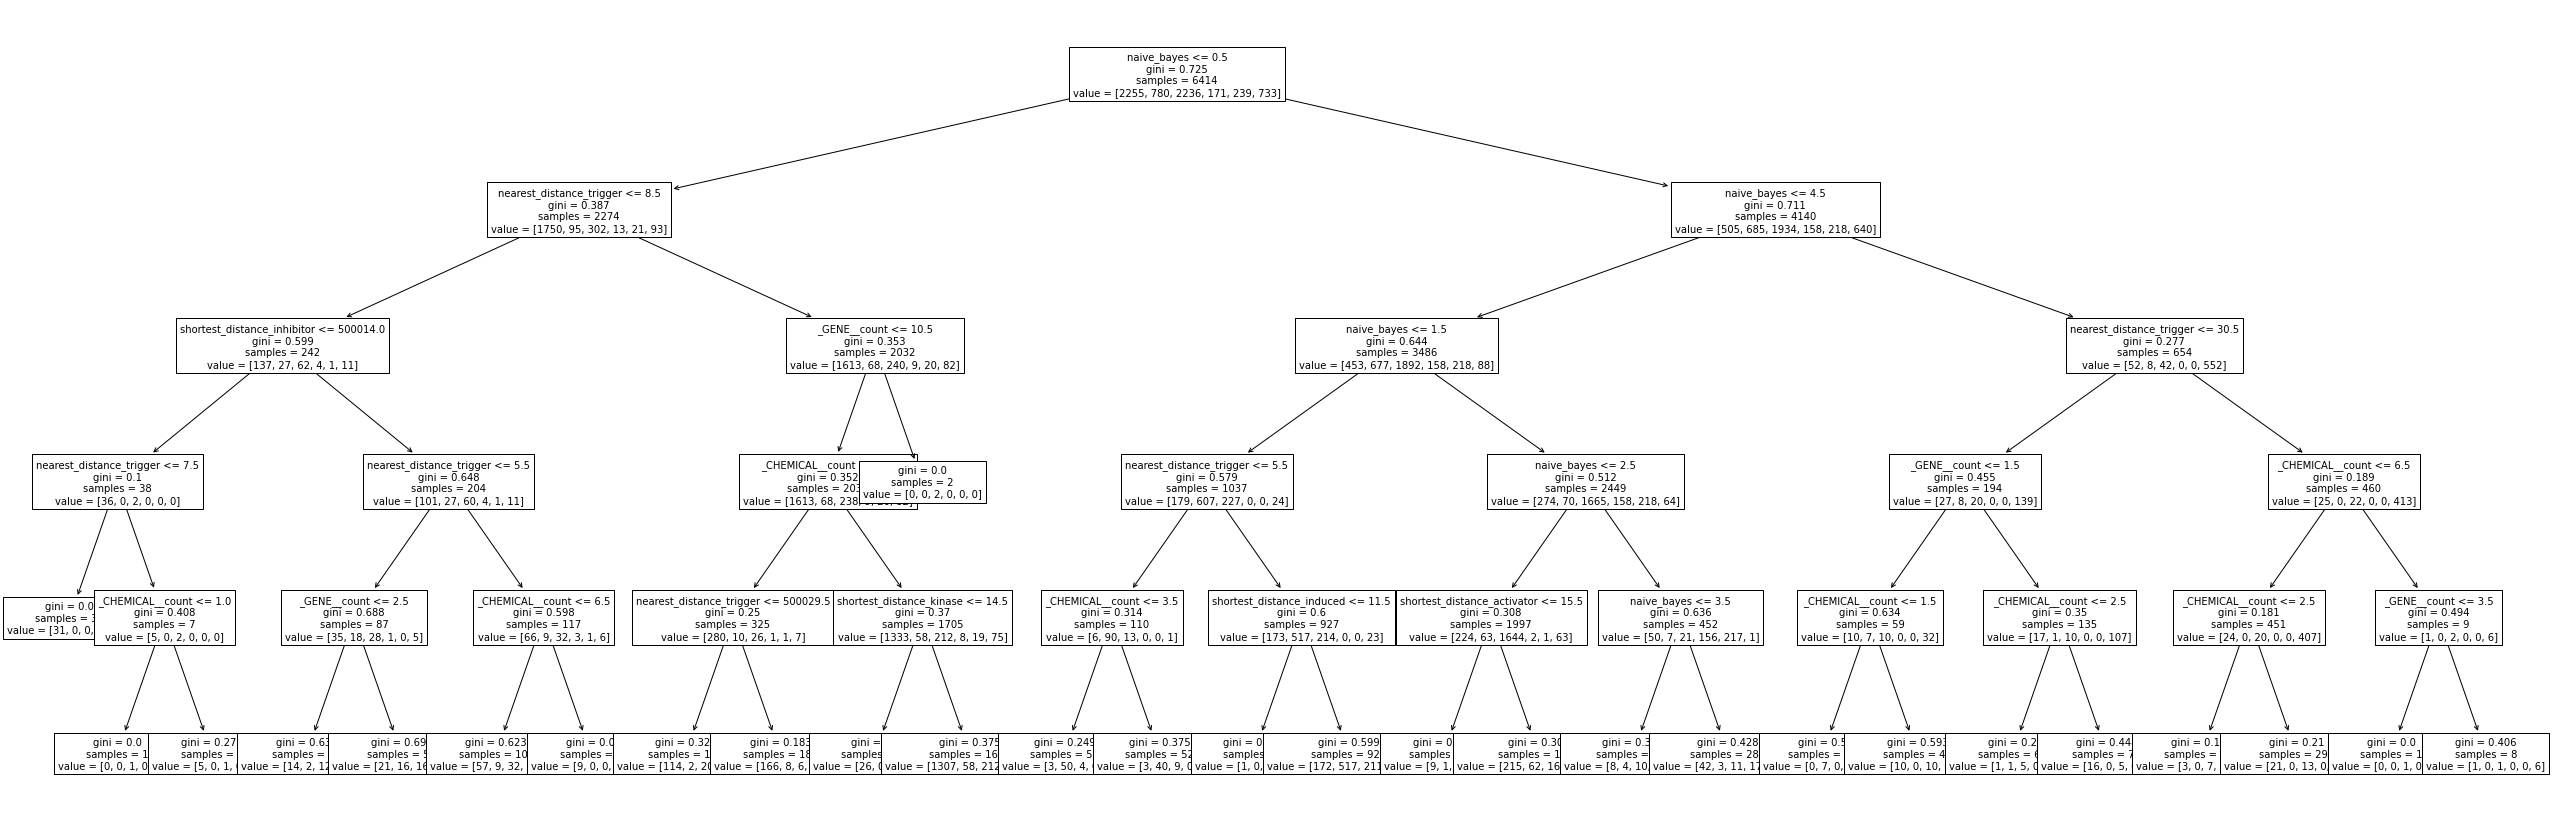

              precision    recall  f1-score   support

           1       0.59      0.79      0.67       780
           2       0.83      0.74      0.78      2236
           3       0.82      0.81      0.82       171
           4       0.74      0.87      0.80       239
           5       0.85      0.74      0.79       733

   micro avg       0.76      0.76      0.76      4159
   macro avg       0.76      0.79      0.77      4159
weighted avg       0.78      0.76      0.76      4159

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      2255
           1       0.59      0.79      0.67       780
           2       0.83      0.74      0.78      2236
           3       0.82      0.81      0.82       171
           4       0.74      0.87      0.80       239
           5       0.85      0.74      0.79       733

    accuracy                           0.77      6414
   macro avg       0.77      0.79      0.77      6414
weighted avg       0.78

In [17]:
df_train_prediction = load_valtest_pred(local_train_prediction_file)

t_m, df_train_prediction["shortcut_pred"] = train_and_predict(df_train_prediction, min_df=1)

plot_tree(t_m)


print_report(df_train_prediction["y"], df_train_prediction["shortcut_pred"], False, pos_labels)

print_report(df_train_prediction["y"], df_train_prediction["shortcut_pred"], False, all_labels)

## Val GT predictions


In [18]:
df_val = load_valtest_pred(local_val_prediction_file)


df_val["shortcut_pred"] = train_and_predict(df_val, min_df=1)[1]




print_report(df_val["gold"],df_val["shortcut_pred"])

['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(3550, 14)
(3550, 14)
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1128
           1       0.55      0.70      0.61       550
           2       0.76      0.73      0.75      1102
           3       0.70      0.83      0.76       116
           4       0.77      0.82      0.79       199
           5       0.89      0.63      0.74       455

    accuracy                           0.71      3550
   macro avg       0.73      0.74      0.73      3550
weighted avg       0.73      0.71      0.72      3550

\begin{tabular}{lrrrr}
\toprule
{} & precision & recall & f1-score & support \\
\midrule
0            &      71.0 &   71.1 &     71.0 &    1128 \\
1            &      55.0 &   69.6 &     61.5 &     550 \\
2            &      76.5 &   73.0 &     74.7 &    1102 \\
3            &      69.6 &   82.8 &     75.6 &     116 

,precision,recall,f1-score,support
0,0.709735,0.710993,0.710363,1128.000000
1,0.550287,0.696364,0.614767,550.000000
2,0.764986,0.729583,0.746865,1102.000000
3,0.695652,0.827586,0.755906,116.000000
4,0.768868,0.819095,0.793187,199.000000
5,0.888545,0.630769,0.737789,455.000000
accuracy,0.714085,0.714085,0.714085,0.714085
macro avg,0.729679,0.735732,0.726480,3550.000000
weighted avg,0.727955,0.714085,0.716530,3550.000000


['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(3550, 14)
(3550, 14)


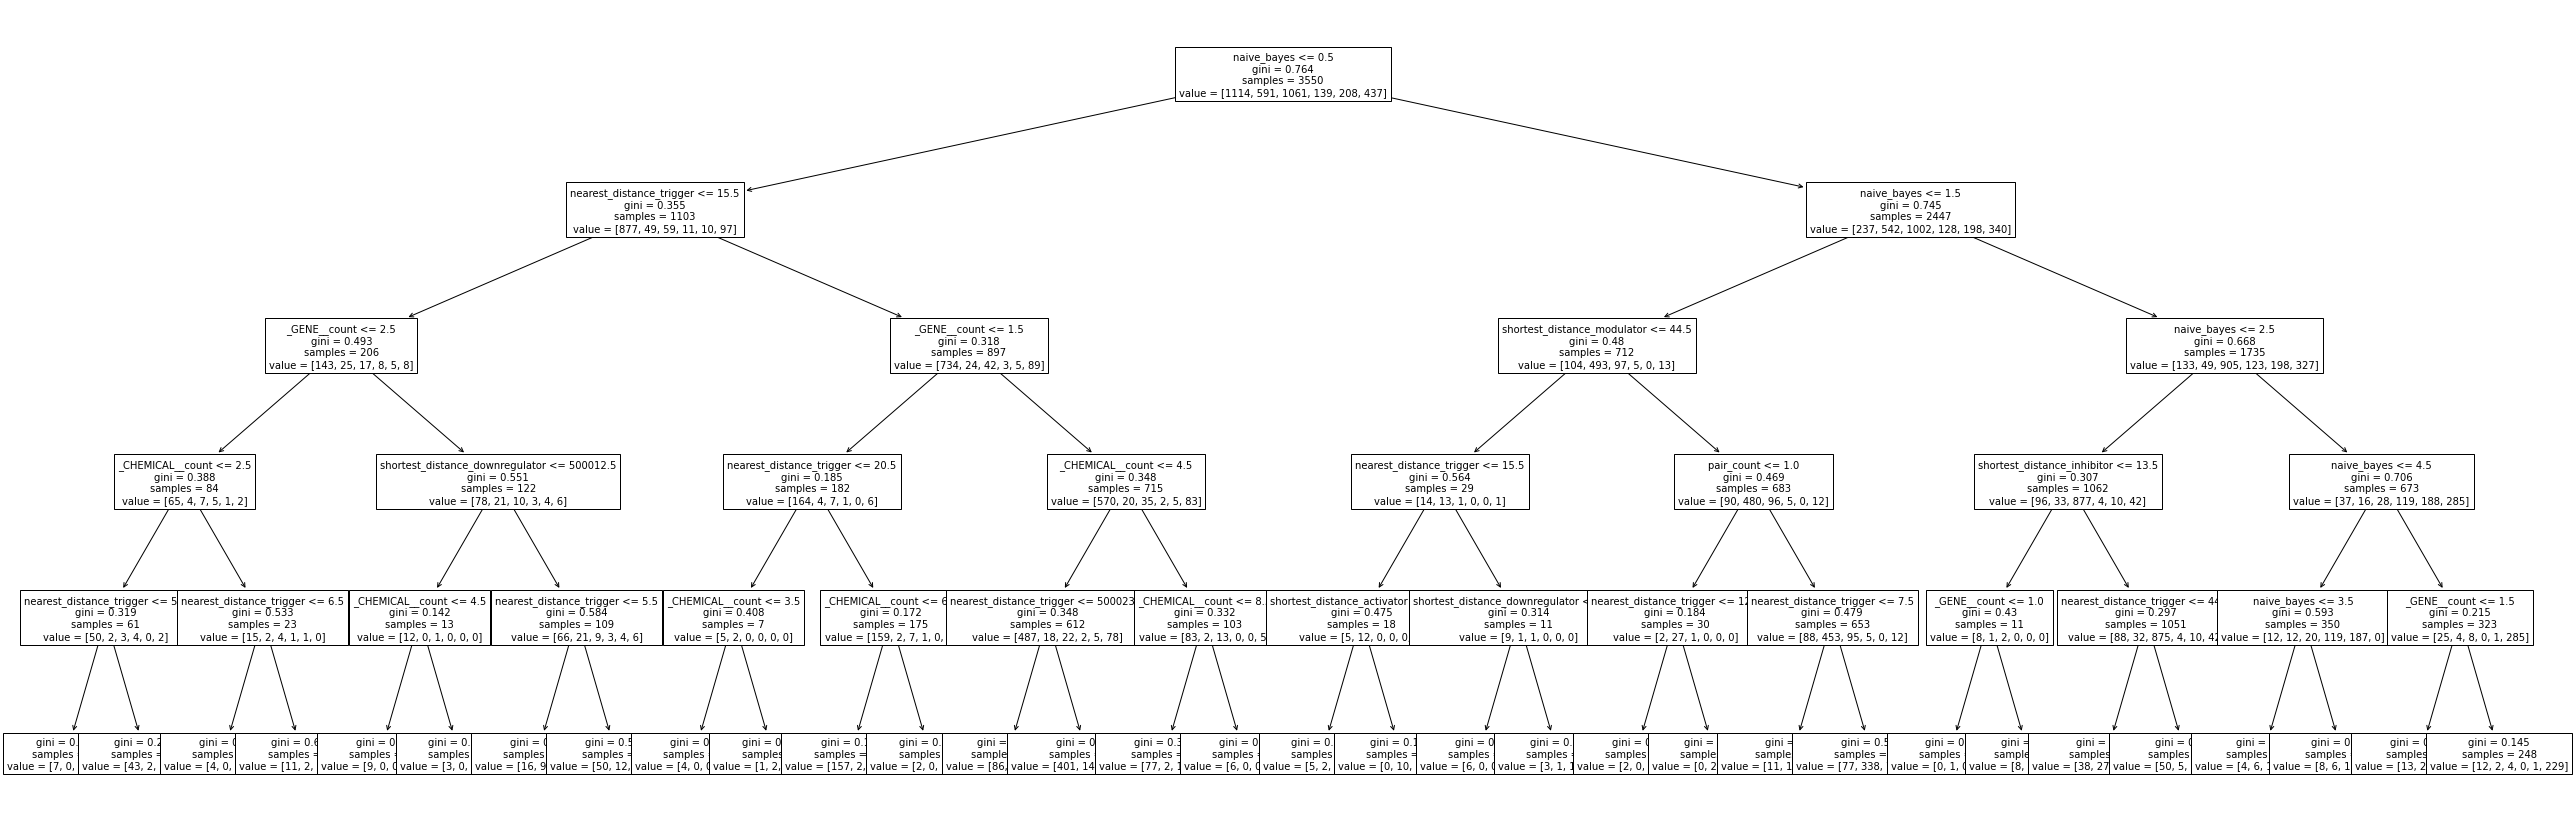

              precision    recall  f1-score   support

           1       0.71      0.83      0.77       591
           2       0.83      0.82      0.83      1061
           3       0.82      0.81      0.82       139
           4       0.86      0.88      0.87       208
           5       0.88      0.65      0.75       437

   micro avg       0.80      0.80      0.80      2436
   macro avg       0.82      0.80      0.81      2436
weighted avg       0.81      0.80      0.80      2436

\begin{tabular}{lrrrr}
\toprule
{} & precision & recall & f1-score & support \\
\midrule
1            &      70.8 &   83.4 &     76.6 &     591 \\
2            &      83.3 &   82.5 &     82.9 &    1061 \\
3            &      81.9 &   81.3 &     81.6 &     139 \\
4            &      85.8 &   87.5 &     86.7 &     208 \\
5            &      88.2 &   65.2 &     75.0 &     437 \\
micro avg    &      80.5 &   80.0 &     80.2 &    2436 \\
macro avg    &      82.0 &   80.0 &     80.5 &    2436 \\
weighted avg &  

In [19]:
df_val_prediction = load_valtest_pred(local_val_prediction_file)

t_m, df_val_prediction["shortcut_pred"] = train_and_predict(df_val_prediction, min_df=1)

plot_tree(t_m)


print_report(df_val_prediction["y"], df_val_prediction["shortcut_pred"], True, pos_labels)

print_report(df_val_prediction["y"], df_val_prediction["shortcut_pred"], False, all_labels)

## Test 

In [20]:
df_test = load_valtest_pred(local_test_prediction_file)


print_report_original(df_test, "y_raw", test_gold_file )


Running command
java -cp ../thirdparty/bc6chemprot_eval.jar org.biocreative.tasks.chemprot.main.Main -TP TRUE -FP TRUE -FN TRUE /var/folders/7v/5_mr86mx7l9g94fxzdpdx0nw0000gn/T/tmpdelt716_ ../temp/data/chemprot_test_gold_standard.tsv

The file:
	./out/eval.txt
was successfully created.

The file:
	./out/tp.txt
was successfully created.

The file:
	./out/fp.txt
was successfully created.

The file:
	./out/fn.txt
was successfully created.

['\n', 'Total annotations: 3458\n', 'Total predictions: 3697\n', 'TP: 2719\n', 'FN: 739\n', 'FP: 978\n', 'Precision: 0.7354611847443874\n', 'Recall: 0.7862926547137074\n', 'F-score: 0.7600279524807828']


c,FN,FP,TP,P,R,F
y,,,,,,
CPR:3,205.0,319.0,460.0,0.590501,0.691729,0.637119
CPR:4,343.0,286.0,1318.0,0.821696,0.793498,0.807351
CPR:5,43.0,56.0,152.0,0.730769,0.779487,0.754342
CPR:6,31.0,54.0,262.0,0.829114,0.894198,0.860427
CPR:9,117.0,224.0,527.0,0.701731,0.818323,0.755556
total,739.0,939.0,2719.0,0.743302,0.786293,0.764193


In [21]:
l = 'CPR:3'
tp = df_test.query(f"y_raw=='{l}' and gold_raw=='{l}'").shape[0]
fp = df_test.query(f"y_raw=='{l}' and gold_raw!='{l}'").shape[0]
fn = df_test.query(f"y_raw!='{l}' and gold_raw=='{l}'").shape[0]


fn, fp, tp

(204, 327, 461)

In [22]:
df_test = load_valtest_pred(local_test_prediction_file)

print_report(df_test["gold"],df_test["y"], labels=pos_labels)

              precision    recall  f1-score   support

           1       0.59      0.69      0.63       665
           2       0.82      0.80      0.81      1648
           3       0.73      0.79      0.76       195
           4       0.79      0.89      0.84       293
           5       0.70      0.82      0.76       643

   micro avg       0.74      0.79      0.76      3444
   macro avg       0.72      0.80      0.76      3444
weighted avg       0.75      0.79      0.77      3444

\begin{tabular}{lrrrr}
\toprule
{} & precision & recall & f1-score & support \\
\midrule
1            &      58.5 &   69.3 &     63.5 &     665 \\
2            &      82.2 &   80.3 &     81.3 &    1648 \\
3            &      72.8 &   79.5 &     76.0 &     195 \\
4            &      78.7 &   89.4 &     83.7 &     293 \\
5            &      70.1 &   82.0 &     75.6 &     643 \\
micro avg    &      73.8 &   79.2 &     76.4 &    3444 \\
macro avg    &      72.4 &   80.1 &     76.0 &    3444 \\
weighted avg &  

,precision,recall,f1-score,support
1,0.585025,0.693233,0.634549,665.0
2,0.821850,0.803398,0.812519,1648.0
3,0.727700,0.794872,0.759804,195.0
4,0.786787,0.894198,0.837061,293.0
5,0.700798,0.819596,0.755556,643.0
micro avg,0.738166,0.792393,0.764319,3444.0
macro avg,0.724432,0.801059,0.759898,3444.0
weighted avg,0.745207,0.792393,0.766623,3444.0


### Predict Test on Test GT fit

In [23]:
df_test = load_valtest_pred(local_test_prediction_file)


df_test["shortcut_pred"] = train_and_predict(df_test, min_df=1)[1]



print_report(df_test["gold"],df_test["shortcut_pred"], labels=pos_labels)



['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(5703, 14)
(5703, 14)
              precision    recall  f1-score   support

           1       0.45      0.68      0.54       665
           2       0.73      0.72      0.73      1648
           3       0.66      0.72      0.69       195
           4       0.70      0.75      0.73       293
           5       0.69      0.60      0.64       643

   micro avg       0.64      0.69      0.67      3444
   macro avg       0.64      0.70      0.66      3444
weighted avg       0.66      0.69      0.67      3444

\begin{tabular}{lrrrr}
\toprule
{} & precision & recall & f1-score & support \\
\midrule
1            &      44.7 &   68.0 &     53.9 &     665 \\
2            &      72.9 &   72.1 &     72.5 &    1648 \\
3            &      65.6 &   72.3 &     68.8 &     195 \\
4            &      70.4 &   75.4 &     72.8 &     293 \\
5            &      68.8 &   60.5 &     64.4 &     

,precision,recall,f1-score,support
1,0.447082,0.679699,0.539379,665.0
2,0.729001,0.721481,0.725221,1648.0
3,0.655814,0.723077,0.687805,195.0
4,0.703822,0.754266,0.728171,293.0
5,0.688496,0.604977,0.644040,643.0
micro avg,0.640257,0.694541,0.666295,3444.0
macro avg,0.644843,0.696700,0.664923,3444.0
weighted avg,0.660717,0.694541,0.672313,3444.0


### Predict Test on Test Prediction fit 

['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(5703, 14)
(5703, 14)


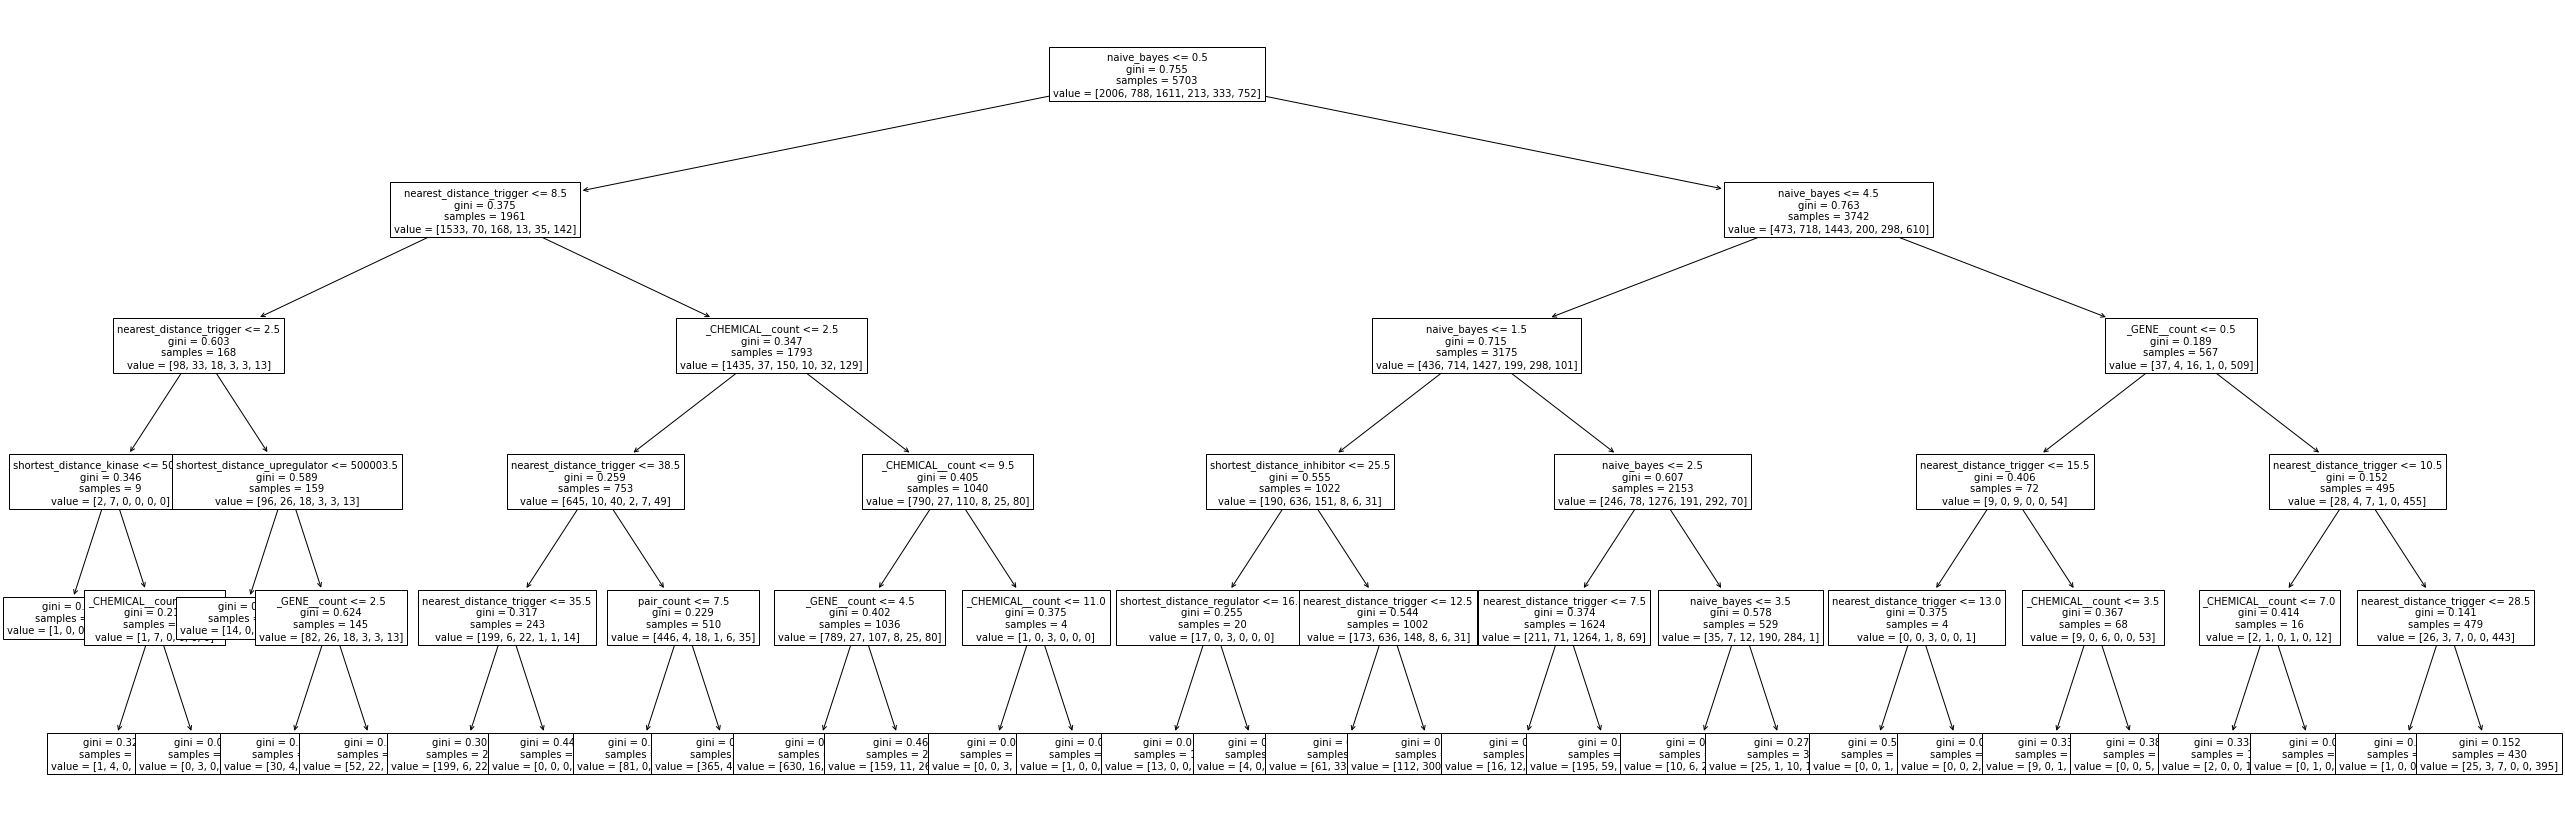

              precision    recall  f1-score   support

           1       0.64      0.82      0.72       788
           2       0.78      0.79      0.78      1611
           3       0.83      0.84      0.83       213
           4       0.84      0.80      0.82       333
           5       0.90      0.68      0.77       752

   micro avg       0.77      0.78      0.77      3697
   macro avg       0.80      0.78      0.78      3697
weighted avg       0.78      0.78      0.77      3697

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2006
           1       0.64      0.82      0.72       788
           2       0.78      0.79      0.78      1611
           3       0.83      0.84      0.83       213
           4       0.84      0.80      0.82       333
           5       0.90      0.68      0.77       752

    accuracy                           0.77      5703
   macro avg       0.80      0.78      0.78      5703
weighted avg       0.78

,precision,recall,f1-score,support
1,0.447082,0.679699,0.539379,665.0
2,0.729001,0.721481,0.725221,1648.0
3,0.655814,0.723077,0.687805,195.0
4,0.703822,0.754266,0.728171,293.0
5,0.688496,0.604977,0.644040,643.0
micro avg,0.640257,0.694541,0.666295,3444.0
macro avg,0.644843,0.696700,0.664923,3444.0
weighted avg,0.660717,0.694541,0.672313,3444.0


In [24]:
df_test_prediction = load_valtest_pred(local_test_prediction_file)

t_m, df_test_prediction["shortcut_pred"] = train_and_predict(df_test_prediction, min_df=1)

plot_tree(t_m)


print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], True, pos_labels)

print_report(df_test_prediction["y"], df_test_prediction["shortcut_pred"], False, all_labels)




In [25]:
print_report(df_test_prediction.query("y != gold")["y"], df_test_prediction.query("y != gold")["shortcut_pred"], False, all_labels)

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       396
           1       0.68      0.73      0.71       327
           2       0.54      0.62      0.58       287
           3       0.73      0.69      0.71        58
           4       0.68      0.70      0.69        71
           5       0.84      0.62      0.71       225

    accuracy                           0.65      1364
   macro avg       0.68      0.66      0.67      1364
weighted avg       0.66      0.65      0.65      1364



In [26]:
print_report(df_test_prediction.query("y == gold")["y"], df_test_prediction.query("y == gold")["shortcut_pred"], False, all_labels)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1610
           1       0.61      0.88      0.72       461
           2       0.84      0.82      0.83      1324
           3       0.86      0.89      0.88       155
           4       0.89      0.82      0.85       262
           5       0.93      0.70      0.80       527

    accuracy                           0.81      4339
   macro avg       0.83      0.82      0.82      4339
weighted avg       0.83      0.81      0.82      4339



In [27]:
get_top_discrimintary_keywords(t_m, 0)

[('_gene_', -2.706116931609035),
 ('_chemical_', -2.7086175580683856),
 ('binding', -3.97473926334451),
 ('receptor', -4.610925404978796),
 ('cells', -4.960911360766732),
 ('activity', -5.071576928654252),
 ('protein', -5.172220454433939),
 ('induced', -5.2020734175836205),
 ('expression', -5.220422556251817),
 ('receptors', -5.245423858457234),
 ('domain', -5.271066289070571),
 ('affinity', -5.3382055919082),
 ('specific', -5.3953640057481485),
 ('kinase', -5.42521696889783),
 ('acid', -5.440484441028619),
 ('bound', -5.448206487122529),
 ('cell', -5.503997846750944),
 ('human', -5.537334267018536),
 ('site', -5.537334267018536),
 ('nm', -5.537334267018536),
 ('selective', -5.616671009255057),
 ('alpha', -5.663627992342828),
 ('mediated', -5.692898374642941),
 ('dependent', -5.7754193983309445),
 ('effect', -5.7754193983309445),
 ('factor', -5.78623031443516),
 ('type', -5.797159384967351),
 ('effects', -5.797159384967351),
 ('using', -5.797159384967351),
 ('_chemical_ _gene_', -5.865

In [28]:
pd.set_option('display.max_colwidth',None)
df_test_prediction.pipe(filter_eval).query("'NEGATIVE' == y_raw ").sample(n=10)\
[["sentence_anonymised", "y_raw", "gold_raw",  "gold", "y","shortcut_pred","relationship_type"]]

,sentence_anonymised,y_raw,gold_raw,gold,y,shortcut_pred,relationship_type
3551,"In conclusion, the _GENE-N_ substitution does not significantly modulate CDA activity toward _CHEMICAL_, and therefore would not contribute to interindividual variability in response to gemcitabine",NEGATIVE,CPR:9,5,0,0,SUBSTRATE
2534,"Two _CHEMICAL_ molecules, imiquimod and gardiquimod, markedly activated both porcine TLR7 and TLR8 whereas only _GENE-Y_, but not TLR8, was activated by the ligands",NEGATIVE,CPR:3,1,0,1,ACTIVATOR
3298,"Furthermore, the EGFR inhibitor _CHEMICAL_ inhibited EGF-induced MMP-9 expression, cell migration and invasion, as well as the activation of PI3K/Akt, suggesting that _GENE-N_/Akt activation occur downstream of EGFR activation",NEGATIVE,CPR:4,2,0,2,INHIBITOR
1987,"The vasopressor response to the calcium channel activator, _CHEMICAL_ , which is mediated through the opening of _GENE-N_ and the subsequent translocation of extracellular calcium, was significantly inhibited by carvedilol (1 mg/kg, iv), suggesting that carvedilol is also a calcium channel antagonist, consistent with our previous in vitro studies",NEGATIVE,CPR:3,1,0,0,ACTIVATOR
1988,"The vasopressor response to the calcium channel activator, BAY-K-8644, which is mediated through the opening of _GENE-N_ and the subsequent translocation of extracellular calcium, was significantly inhibited by _CHEMICAL_ (1 mg/kg, iv), suggesting that carvedilol is also a calcium channel antagonist, consistent with our previous in vitro studies",NEGATIVE,CPR:4,2,0,0,INHIBITOR
4241,"Coumarin 7-hydroxylation, catalyzed by _GENE-Y_ , was strongly inhibited by 2'-methoxy-5,7-dihydroxyflavone, 2-ethynylnaphthalene, 2'-methoxyflavone, _CHEMICAL_, acenaphthene, acenaphthylene, naphthalene, 1-acetylpyrene, flavanone, chrysin, 3-ethynylphenanthrene, flavone, and 7-hydroxyflavone; these chemicals induced Type I spectral changes with low Ks values",NEGATIVE,CPR:4,2,0,5,INHIBITOR
1738,"While either blockage of HO activity by the HO inhibitor, tin protoporphyrin IX, or down-regulation of HO-1 expression by HO-1 small interfering RNA (siRNA) reversed the inhibitory effects of H(2)S on _GENE-Y_ expression and _CHEMICAL_ production, HO-1 overexpression produced the same inhibitory effects of H(2)S",NEGATIVE,CPR:9,5,0,1,PRODUCT-OF
2688,"Others kinase inhibitors used recently in cancer therapy include Dasatinib (BMS-354825) specific for ABL non-receptor cytoplasmic kinase, Gefitinib (Iressa), Erlotinib (OSI-774, _CHEMICAL_ ) and Sunitinib (SU 11248, Sutent) specific for _GENE-N_ kinase, AMN107 (Nilotinib) and INNO-406 (NS-187) specific for c-KIT kinase",NEGATIVE,CPR:4,2,0,0,INHIBITOR
1373,"However at IC80, _CHEMICAL_ (+134.4%) and flunixin (+29.7%) had greater _GENE-Y_ selectivity than at IC50, and meloxicam (-41.2%) and carprofen (-12.9%) had lower COX-2 selectivity than at IC50",NEGATIVE,CPR:4,2,0,2,INHIBITOR
2684,"Others kinase inhibitors used recently in cancer therapy include Dasatinib (BMS-354825) specific for ABL non-receptor cytoplasmic kinase, Gefitinib (Iressa), _CHEMICAL_ (OSI-774, Tarceva) and Sunitinib (SU 11248, Sutent) specific for _GENE-N_ kinase, AMN107 (Nilotinib) and INNO-406 (NS-187) specific for c-KIT kinase",NEGATIVE,CPR:4,2,0,0,INHIBITOR


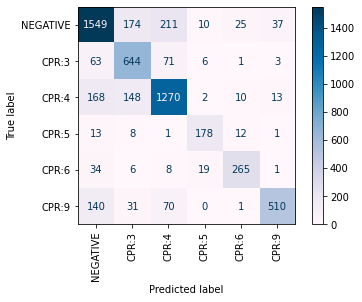

In [29]:
plot_confusionmatrix(df_test_prediction["y"], df_test_prediction["shortcut_pred"])